# Demand Forecasting Project
Let's check my prediction model on demand forecasting !

*Valentino Prasetya, 25 April 2021*

**Authors Note :**

This notebook is a part of my job application as data scientist role in a company. In this assignment, I am given the opportunity to showcase my skills in data science by analyzing a retail sales dataset. To be honest, a number of notebooks have already analyzed similar demand forecasting problem. A notebook I referred to are ones created by [Arindam Dutta](https://www.kaggle.com/arindamgot/eda-prophet-mlp-neural-network-forecasting) which is programmed in R language. Understanding them is a challenge in itself, however I am grateful that I am able to learn a lot from this experience. Aside from using these reference, I also did a lot of experimenting in data visualization. Hope you enjoy!

![Cover_Retail](https://f.hubspotusercontent10.net/hub/491011/hubfs/BLOG_-ecommerce-and-the-cloud.jpg?width=1600&name=BLOG_-ecommerce-and-the-cloud.jpg)  

**Case Study :**

I am working as a data scientist in a retail business. My business owner asked me to build a forecasting model to predict future sales. As a good data scientist, I made a notebook to give insights about the data and document the process of building my forecasting model.


**Goals :**

- Perform Explanatory Data Analysis (EDA)
- Build model to perform demand forecasting

**Limitations**
- The model doesn't count the relation between sales time series across different items and stores. Hence, time series is modeled individually per item and per store.
- Some item categories in some stores namely item 1 in store 6, 8, and 10, and item 32 in store 10 is ignored because missing values (explanation in the notebook).

**Setting up the library**

Import all the required Python libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = None
pd.options.display.max_rows = 30

# Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go

# Statistical Analysis
import statsmodels.api

pd.options.mode.chained_assignment = None  # default='warn'

## Understanding the Data

### Import the data

In [2]:
# Import Data
df = pd.read_excel("online-test-dataset.xlsx")
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


In [4]:
df.shape

(858220, 4)

In [5]:
df.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [6]:
# Check Number of Missing Values
number_of_nulls = df.isnull().sum()

with pd.option_context('display.max_rows', None):
    print(number_of_nulls)

date        0
store       0
item        0
sales    9918
dtype: int64


There are 9918 missing values in sales

### Handling Missing Values

In [7]:
df2 = df.copy()

In [8]:
df_null = df2[pd.isnull(df2['sales'])]

In [9]:
df_null.groupby(['store', 'item']).agg('count')['date']

store  item
6      1       1734
       31      1095
       47       730
8      1       1734
       37       699
       47       730
10     1       1734
       32       732
       37       730
Name: date, dtype: int64

Missing values detected in:
1. Store 6 : Item 1, 31, 47
2. Store 8 : Item 1, 37, 47
3. Store 10: Item 1, 32, 37

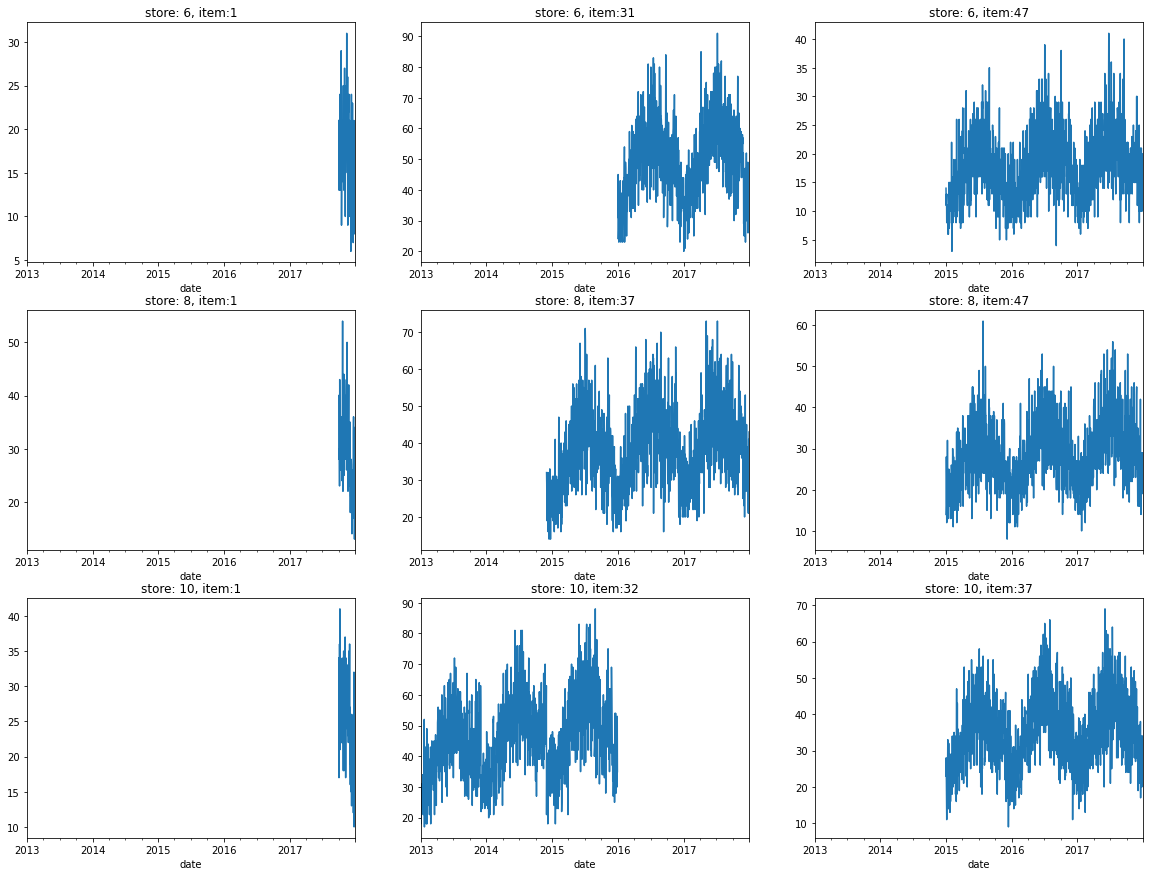

In [10]:
# Check distribution of missing values
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
missing_items = [(6, 1), (6, 31), (6, 47), (8, 1), (8, 37), (8, 47), (10, 1), (10, 32), (10, 37)]
for i, (store, item) in enumerate(missing_items):
    df2[(df2['store'] == store) & (df2['item'] == item)].set_index('date')['sales'].plot(
        title='store: %s, item:%s' %(store, item),
        ax=axes[i//3, i%3]
    )
plt.show()

The plot above shows the location of missing values. All items have missing data at the start, showing either that the store start selling the item after 2014, except store 10 item 32 which have no record of demand after year 2016. 

For demand for item 1 in store 6, 8, and 10, it will be hard to forecast the data since available data is few and some data is required for testing. For store 10 item 32, it will be difficult to forecast since recent data is missing.

### Handling Missing Values
Looking at the missing values, there is high probability that the missing values is not random. In case of no record / haven't start selling the item, I assume that it is best to drop the missing value

In [11]:
# Impute missing sales with 0
df2 = df2.dropna(how='any')

In [12]:
df2.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

No missing values detected

In [13]:
df2.shape

(848302, 4)

### Data Visualization & Cleaning

In this section, explanatory data analysis will be performed.

In [14]:
df3 = df2.copy()

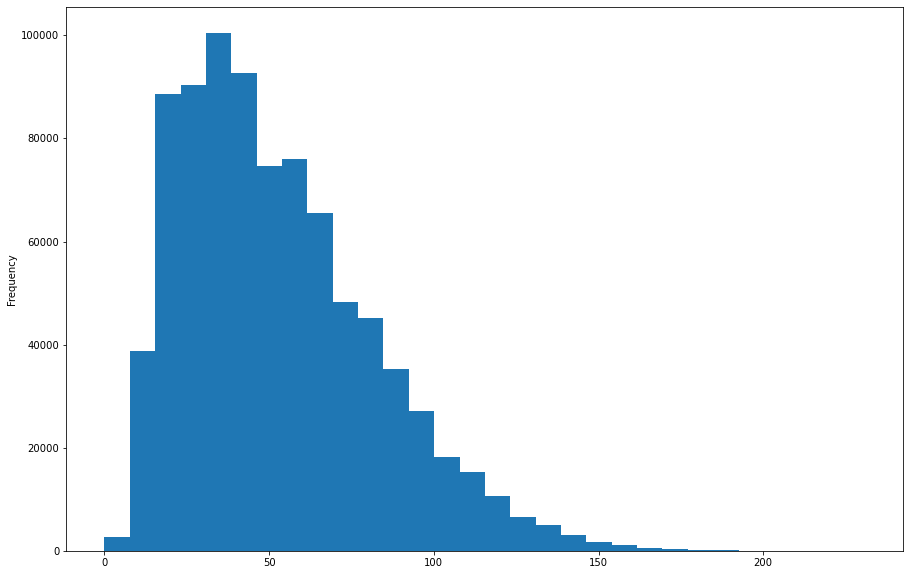

In [15]:
# Sales histogram
df3['sales'].plot(kind='hist', bins=30, figsize=(15,10))
plt.show()

From the histogram, the distribution is skewed to the right

In [16]:
# Check extreme values
df3[df3['sales'] <= 1]

,date,store,item,sales
11329,2014-01-09,7,1,1.0
12050,2015-12-31,7,1,1.0
64289,2014-01-15,6,4,0.0
84341,2013-12-12,7,5,1.0
475123,2013-12-30,1,27,1.0


There is one item that have zero sales.

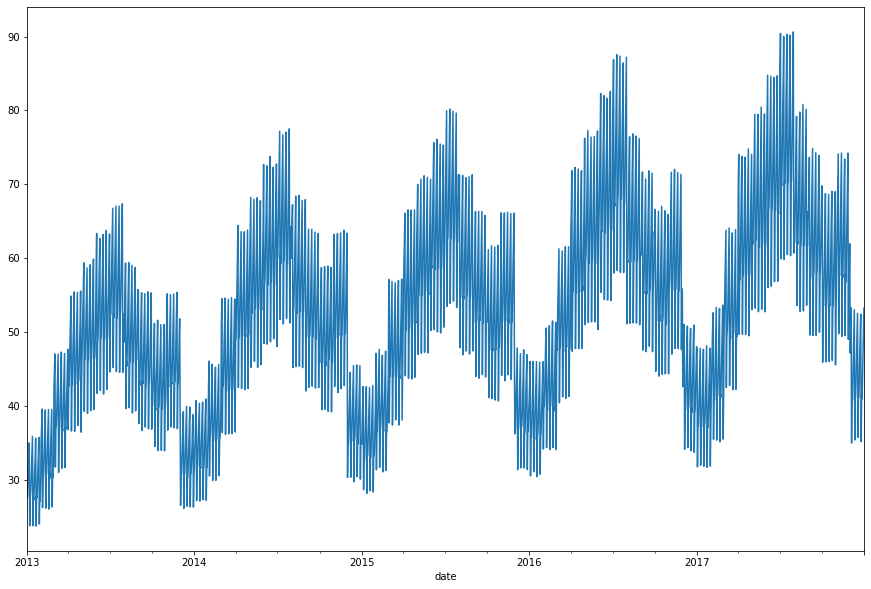

In [17]:
# Check the trend of the data grouped by date
mean_sales_grouped_by_date = df3.groupby('date')['sales'].agg('mean')
mean_sales_grouped_by_date.plot(figsize=(15,10))
plt.show()

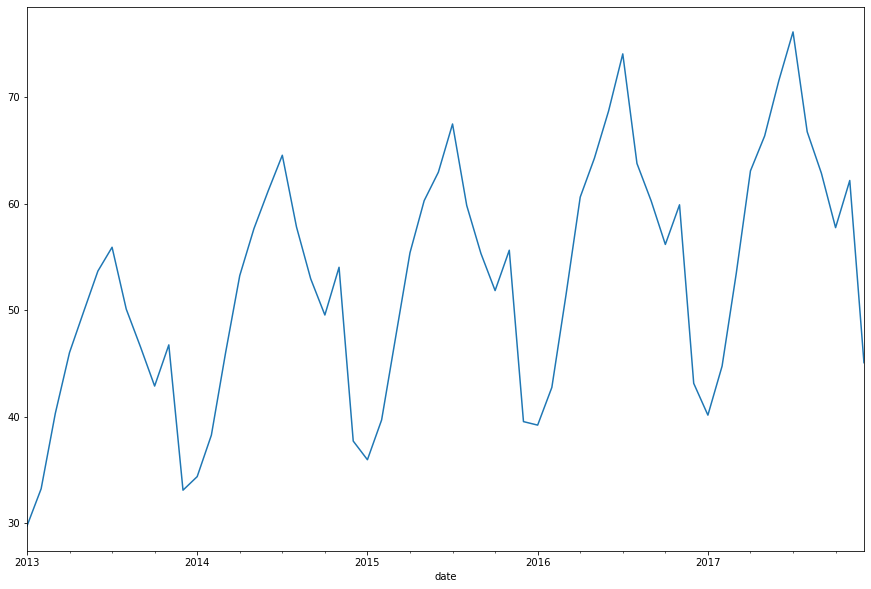

In [18]:
# Check the trend of the data grouped by month
mean_sales_grouped_by_month = df3.groupby(pd.Grouper(key='date', freq='M'))['sales'].agg('mean')
mean_sales_grouped_by_month.plot(figsize=(15,10))
plt.show()

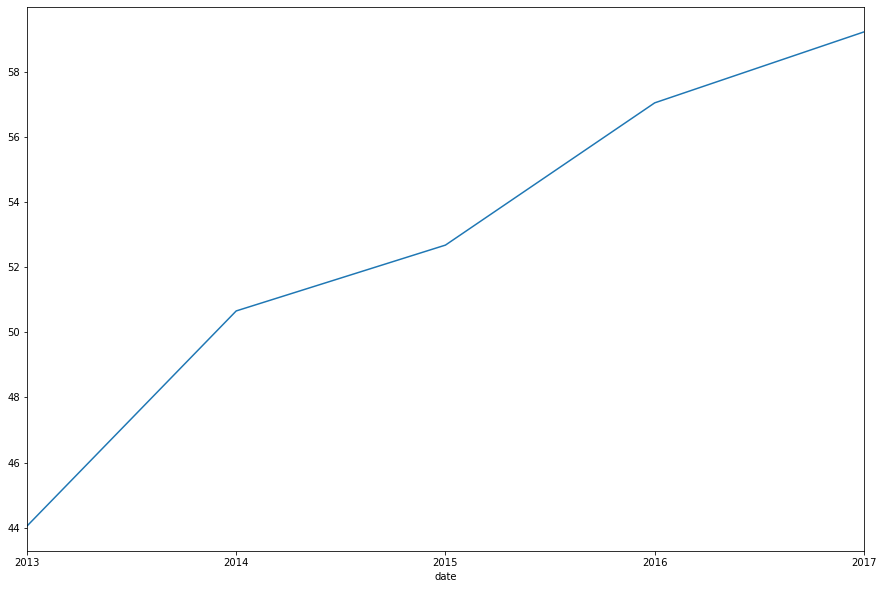

In [19]:
# Check the trend of the data grouped by year
mean_sales_grouped_by_year = df3.groupby(pd.Grouper(key='date', freq='Y'))['sales'].agg('mean')
mean_sales_grouped_by_year.plot(figsize=(15,10))
plt.show()

From the graphs above, it can be concluded that:
1. The demand has positive trend yearly
2. The demand have monthly seasonality

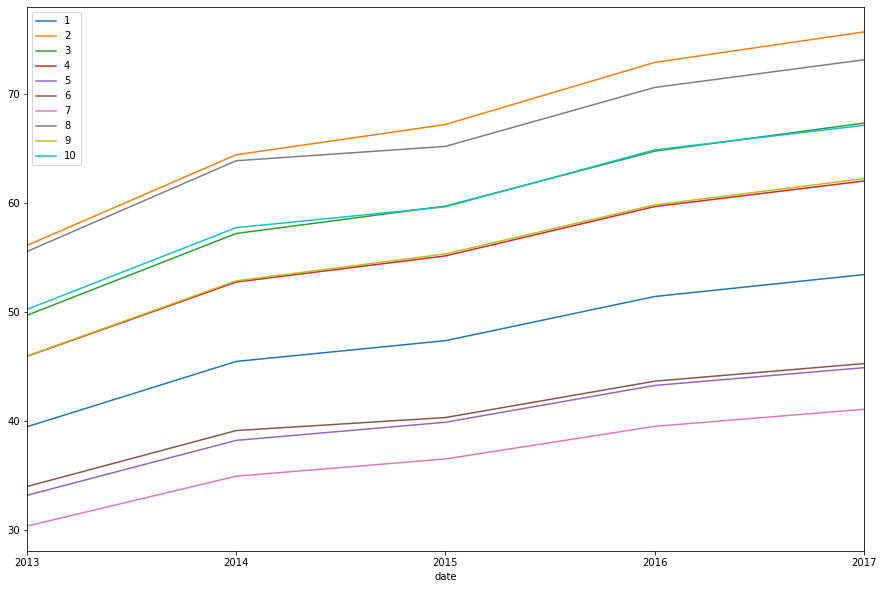

In [20]:
# Check the trend of the data grouped by store
mean_sales_grouped_by_store = df3.groupby(by = ['store', pd.Grouper(key='date', freq='Y')])['sales'].agg('mean')

for store in mean_sales_grouped_by_store.index.get_level_values(0).unique():
    mean_sales_grouped_by_store[store].plot(label=store, figsize=(15,10))
plt.legend(loc='best')
plt.show()

Different store have similar trend, but significant sales different

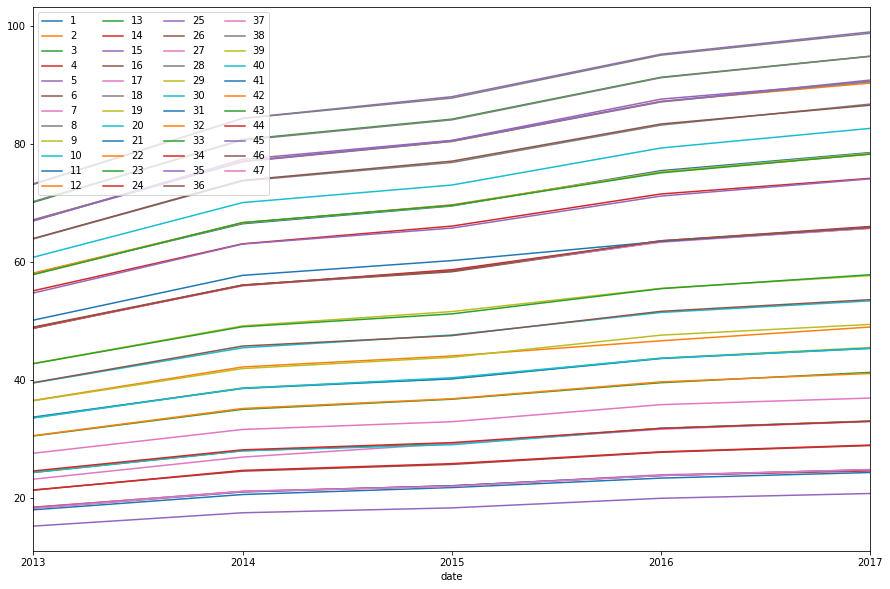

In [21]:
# Check the trend of the data grouped by items
mean_sales_grouped_by_item = df3.groupby(by = ['item', pd.Grouper(key='date', freq='Y')])['sales'].agg('mean')

for item in mean_sales_grouped_by_item.index.get_level_values(0).unique():
    mean_sales_grouped_by_item[item].plot(label=item, figsize=(15,10))
plt.legend(ncol=4, loc='best')
plt.show()

Different items also have similar trend, but significantly different demand

## Building the Prediction Model

### Setting the Metric

A lot of metrics are used for error measurement: MSE, RMSE, MAE, MAPE, sMAPE. MAPE is one of the most popular metric for evaluating forecasting performance. Formula given by:
$$MAPE = \frac{1}{n} * \sum_{t=1}^n \left\lvert{\frac{A_t-F_t}{A_t}}\right\rvert $$
MAPE have advantage that it is expressed as a percentage, which is scale-dependent. Hence, it can be used to forecast on various values. However, it has disadvantage that it heavily penalized negative error (forecast higher than actual) and favor underforecast model. It also takes undefined values when actual is 0 and extreme values when actual is 1, which can happen in demand forecasting. 

In this case, sMAPE is used instead. sMAPE (symetric Mean Absolute Percentage Error) is an alternative to MAPE, which have similar penalty on negative and positive error. The formula of sMAPE is given below:
$$sMAPE = \frac{1}{n} * \sum_{t=1}^n \left\lvert{\frac{A_t-F_t}{(A_t+F_t)/2}}\right\rvert$$

In this demand forecasting, sMAPE is used for the metric since it has better penalty system for demand forecasting.

In [22]:
def smape(actual, forecast):
    return np.mean(abs(actual-forecast) / abs(actual + forecast)/2)

### Modeling Preparation

In [23]:
print('Minimum Date: ', df3['date'].min())
print('Maximum Date: ', df3['date'].max())

Minimum Date:  2013-01-01 00:00:00
Maximum Date:  2017-12-31 00:00:00


In [24]:
# Get 90 days before latest data
from datetime import timedelta
print(df3['date'].max() - timedelta(days=90))

2017-10-02 00:00:00


In [25]:
# Splitting Train and Test(evaluation set) (Take 3 months for evaluation set)
def split(df, store, item, days=90):
    timesplit = df['date'].max() - timedelta(days) # timestamp that separate train and test set
    one_df = df[(df['store'] == store) & (df['item'] == item)][['date', 'sales']] # dataframe of specific store and item
    one_df.columns = ['ds', 'y']
    test = one_df[one_df['ds'] > timesplit]
    train = one_df[one_df['ds'] <= timesplit]
    return(train, test)

### Prophet Model

Prophet model is used because it is a popular and newer model for demand forecasting. This model is created by facebook research team and used in many application across Facebook for producing reliable forecast. Prophet takes into account yearly and monthly seasonality in the data and robust to missing data and shifts in trend.

In [26]:
# Model store 1, item 1 timeseries
train, test = split(df3, 1, 1)
print('Train shape: %s \nTest Shape:%s' %(train.shape, test.shape))

Train shape: (1736, 2) 
Test Shape:(90, 2)


In [27]:
# Prophet model
# https://medium.com/spikelab/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245
from fbprophet import Prophet

def run_prophet(timeserie):
    model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=90, include_history=False)
    forecast = model.predict(forecast)
    return forecast

In [28]:
f = run_prophet(train)
f.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-10-03,22.852774,15.292835,26.585572,22.852774,22.852774,-1.925578,-1.925578,-1.925578,-1.791631,-1.791631,-1.791631,-0.133946,-0.133946,-0.133946,0.0,0.0,0.0,20.927196
1,2017-10-04,22.855461,15.924258,27.360914,22.855461,22.855461,-1.211087,-1.211087,-1.211087,-1.105158,-1.105158,-1.105158,-0.105929,-0.105929,-0.105929,0.0,0.0,0.0,21.644375
2,2017-10-05,22.858148,16.636134,27.691316,22.858148,22.858148,-0.623543,-0.623543,-0.623543,-0.543655,-0.543655,-0.543655,-0.079888,-0.079888,-0.079888,0.0,0.0,0.0,22.234606
3,2017-10-06,22.860836,18.021203,29.707723,22.860836,22.860836,1.133179,1.133179,1.133179,1.191179,1.191179,1.191179,-0.058000,-0.058000,-0.058000,0.0,0.0,0.0,23.994014
4,2017-10-07,22.863523,19.919280,31.440702,22.863523,22.863523,2.895859,2.895859,2.895859,2.938108,2.938108,2.938108,-0.042248,-0.042248,-0.042248,0.0,0.0,0.0,25.759382


In [29]:
test.set_index('ds')['y'].head()

ds
2017-10-03    18.0
2017-10-04    15.0
2017-10-05    20.0
2017-10-06    19.0
2017-10-07    22.0
Name: y, dtype: float64

In [30]:
f.set_index('ds')['yhat'].head()

ds
2017-10-03    20.927196
2017-10-04    21.644375
2017-10-05    22.234606
2017-10-06    23.994014
2017-10-07    25.759382
Name: yhat, dtype: float64

[]

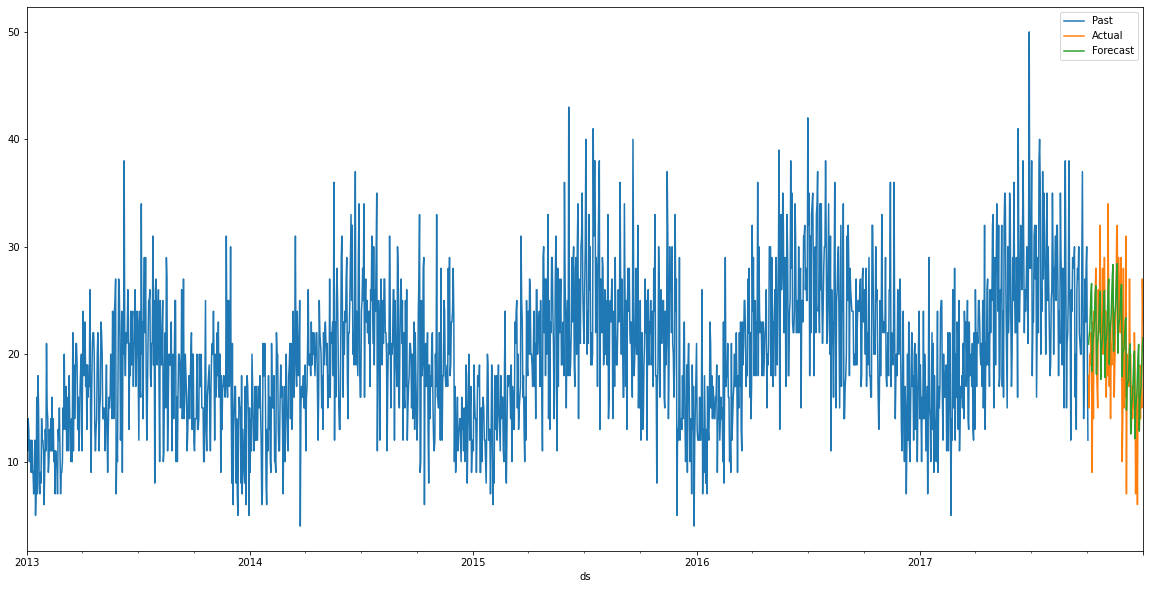

In [31]:
# Plot the result
train.set_index('ds')['y'].plot(label='Past', figsize=(20,10))
test.set_index('ds')['y'].plot(label='Actual')
f.set_index('ds')['yhat'].plot(label='Forecast')
plt.legend(loc='best')
plt.plot()

[]

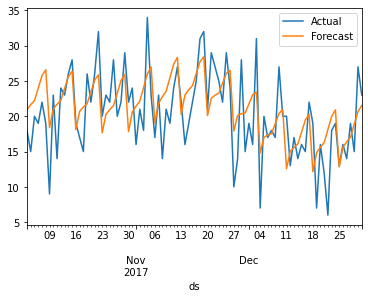

In [32]:
# Plot specifically in the forecast region vs the actual
test.set_index('ds')['y'].plot(label='Actual')
f.set_index('ds')['yhat'].plot(label='Forecast')
plt.legend(loc='best')
plt.plot()

In [33]:
# Check sMAPE score
print(smape(test.set_index('ds')['y'], f.set_index('ds')['yhat']))

0.04943892238890952


In [34]:
def prophet_result(df, store, item, days=90, plot=True):
    train, test = split(df, store, item, days=90)
    f = run_prophet(train)
    actual = test.set_index('ds')['y']
    forecast = f.set_index('ds')['yhat']
    if plot == True:
        actual.plot(label='Actual')
        forecast.plot(label='Forecast')
        plt.legend(loc='best')
        plt.plot()
        print('sMAPE for store %s item %s is %s' %(store, item, smape(actual, forecast)))
    return forecast

sMAPE for store 6 item 31 is 0.03229956357825751


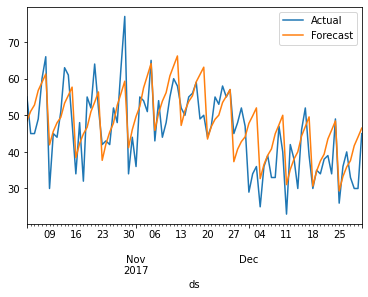

In [35]:
forecast = prophet_result(df3, 6, 31)

In [36]:
forecast.head()

ds
2017-10-03    48.482968
2017-10-04    51.102167
2017-10-05    52.814968
2017-10-06    56.798298
2017-10-07    59.016011
Name: yhat, dtype: float64

We want to get all forecast in every stores and items in one dataframe

In [37]:
# List all stores and items
stores = df3['store'].unique()
print('Stores:', stores)
items = df3['item'].unique()
print('Items:', items)

Stores: [ 1  2  3  4  5  6  7  8  9 10]
Items: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


In [38]:
# Prepare a dataframe of test set
timesplit = df3['date'].max() - timedelta(90) # timestamp that separate train and test set
result = df3[df3['date'] > timesplit]
result.head()

,date,store,item,sales
1736,2017-10-03,1,1,18.0
1737,2017-10-04,1,1,15.0
1738,2017-10-05,1,1,20.0
1739,2017-10-06,1,1,19.0
1740,2017-10-07,1,1,22.0


In [39]:
result.loc[(result['store'] == 1) & (result['item'] == 1), 'yhat'] = list(forecast)
result

,date,store,item,sales,yhat
1736,2017-10-03,1,1,18.0,48.482968
1737,2017-10-04,1,1,15.0,51.102167
1738,2017-10-05,1,1,20.0,52.814968
1739,2017-10-06,1,1,19.0,56.798298
1740,2017-10-07,1,1,22.0,59.016011
...,...,...,...,...,...
858215,2017-12-27,10,47,16.0,NaN
858216,2017-12-28,10,47,21.0,NaN
858217,2017-12-29,10,47,18.0,NaN
858218,2017-12-30,10,47,10.0,NaN


In [ ]:
# Prepare a dataframe of test set
timesplit = df3['date'].max() - timedelta(90) # timestamp that separate train and test set
result = df3[df3['date'] > timesplit]
result.head()

store_item_exception = [(6, 1), (8, 1), (10, 1), (10, 32)]

# Apply prophet to every stores and items except the ones mentioned above.
for store in stores:
    print(store)
    for item in items:
        if (store, item) not in store_item_exception:
            forecast = prophet_result(df3, store, item, plot=False)
            result.loc[(result['store'] == store) & (result['item'] == item), 'yhat'] = list(forecast)

1
2
3
4
5
6


In [244]:
result.head()

,date,store,item,sales,yhat
1736,2017-10-03,1,1,18.0,20.927196
1737,2017-10-04,1,1,15.0,21.644375
1738,2017-10-05,1,1,20.0,22.234606
1739,2017-10-06,1,1,19.0,23.994014
1740,2017-10-07,1,1,22.0,25.759382


In [252]:
result.isnull().sum()

date       0
store      0
item       0
sales      0
yhat     270
dtype: int64

In [253]:
result = result.dropna()

In [256]:
smape(result['sales'], result['yhat'])

0.033038737010940386

In [ ]:
result

## Conclusion & Recommendation

### Conclusion

Distribution and trend of the data have been shown by using Explanatory Data Analysis. While some items and stores have few data and difficult to predict. The author managed to forecast the other complete data byy using the prophet model. It is acquired that the model have overall sMAPE of 3.33%.

### Foreword from Author

Aside from this project, the author see a lot of other forecasting improvement potential in this dataset. While the author choose to use Prophet model because it is really interesting and sometime better than other techniques. The author didn't have enough time to actually compare it to other models. In the future, comparison of this model and other model can be implemented. Using ARIMA and Neural Network are two methods often used in demand forecasting and worth trying. 

### Credit

1. Dutta, Arindam. 2018. [EDA+Prophet+ MLP Neural Network Forecasting](https://www.kaggle.com/arindamgot/eda-prophet-mlp-neural-network-forecasting)
2. Aravena, Matias. 2018. [Forecasting multiple time-series using Prophet in parallel](https://medium.com/spikelab/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245)
3. Taylor, Sean. 2017. [Forecasting at Scale](https://peerj.com/preprints/3190/).